<a href="https://colab.research.google.com/github/sivagunturi/mfr_meta/blob/main/Datasetcreation%2Bmask2face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask2Face
This notebook will guide you through all the steps described in this article to build and train your ML model for removing the face mask of the person's face.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
from keras.models import model_from_json

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [3]:
cd /content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face/

/content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 49.5 MB 1.2 MB/s 
     |████████████████████████████████| 1.0 MB 39.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.3 MB/s 


In [6]:
# Necessary imports
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import download_data
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.architectures import UNet
from utils.model import Mask2FaceModel
from os.path import exists

In [7]:
# setup HW

# is GPU available
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


## 1) Preconditions
First we need a dataset of human faces.

In [8]:
# Check if dataset is already downloaded or needs to be downloaded.
configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if os.path.isdir(dataset_path):
    print('Dataset already downloaded')
else:
    print('Downloading dataset')
    print('Downloading dataset')
    dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
    download_data(configuration.get('dataset_archive_download_url'), dataset_archive_path)
    print('Extracting dataset')
    tar = tarfile.open(dataset_archive_path, 'r:gz')
    tar.extractall('data')
    tar.close()
    print('Done')

Dataset already downloaded


## 2) Data generation
Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

Here are few examples of generated data.


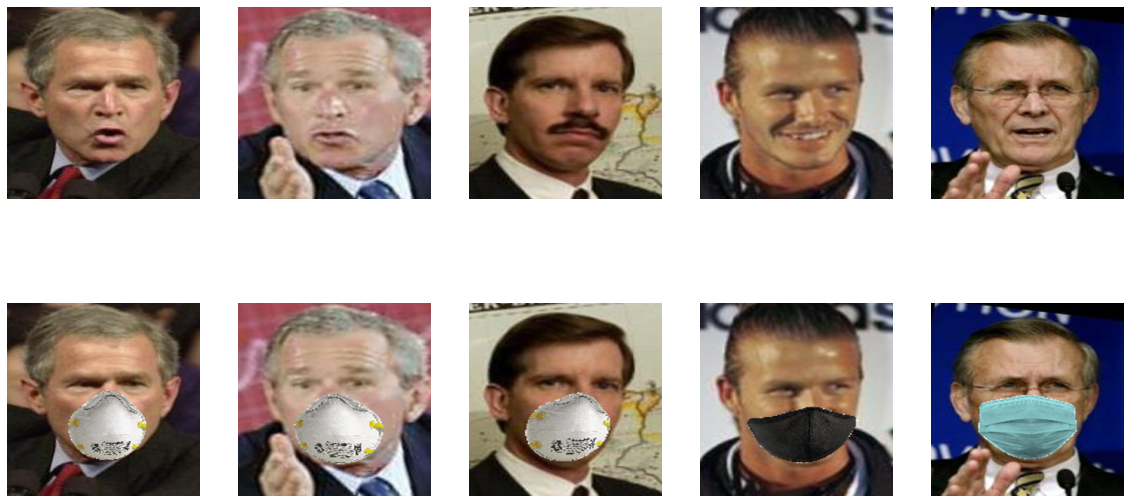

In [9]:
# setup the pipeline and generate data

dg = DataGenerator(configuration)

# train_folder = configuration.get('train_data_path')
# test_folder = configuration.get('test_data_path')

# # if os.path.exists(train_folder) and os.path.exists(test_folder):
# #     print('Testing and training data already generated')
# # else:
# dg.generate_images()

print('Here are few examples of generated data.')
n_examples = 5
inputs, outputs = dg.get_dataset_examples(n_examples)
f, axarr = plt.subplots(2, n_examples, figsize=(20, 10))
for i in range(len(inputs)):
    axarr[1, i].imshow(mpimg.imread(inputs[i]))
    axarr[1, i].axis('off')
    axarr[0, i].imshow(mpimg.imread(outputs[i]))
    axarr[0, i].axis('off')

## 3) Model training
Now we have all the data, and we can initiate model and start training.

In [10]:
# Feel free to experiment with the number of filters, their sizes or any other parameters
filters = (64, 128, 128, 256, 256, 512)
kernels = (7, 7, 7, 3, 3, 3)
input_image_size = (256, 256, 3)
architecture = UNet.RESNET
training_epochs = 20
batch_size = 12

In [11]:
# Create instance of model and start training
model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                   kernels=kernels, configuration=configuration)
model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

model.compute_output_shape(input_shape=(None, 256,256,3))
# model.save("./mask2face_siva_trained")

# If you already have pretrained model you can uncomment next line and load it instead of training new one
# model = Mask2FaceModel.load_model('path_to_your_trained_model.h5')

Using UNet Resnet model
Loading training data from data/train with limit of 10000 images
Loading testing data from data/test with limit of 1000 images
9/9 [==============================] - 59s 4s/step - loss: 0.6300 - acc: 0.1177 - recall: 0.5941 - precision: 0.9883
- TEST -> LOSS:     0.6300, ACC:     0.1177, RECALL:     0.5941, PRECISION:     0.9883
Epoch 1/20
299/299 [==============================] - 4927s 4s/step - loss: 0.2379 - acc: 0.7944 - recall: 0.5058 - precision: 1.0000 - val_loss: 0.1700 - val_acc: 0.7923 - val_recall: 0.4362 - val_precision: 0.9998
Epoch 2/20
299/299 [==============================] - 284s 821ms/step - loss: 0.1477 - acc: 0.8311 - recall: 0.3999 - precision: 1.0000 - val_loss: 0.1498 - val_acc: 0.8380 - val_recall: 0.4257 - val_precision: 0.9998
Epoch 3/20
299/299 [==============================] - 284s 818ms/step - loss: 0.1159 - acc: 0.8904 - recall: 0.3825 - precision: 1.0000 - val_loss: 0.1072 - val_acc: 0.9120 - val_recall: 0.4054 - val_precision: 

TensorShape([None, 256, 256, 3])

## 4) Results
Our model is trained, and we can look at it's performance

In [42]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 3
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=False)
f, axarr = plt.subplots(n_examples, 3, figsize=(10, n_examples * 3))
for i, img in enumerate(input_imgs):
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(input_imgs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(true_output_imgs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')
print('Outputs generated on previously unseen data.')

FileNotFoundError: ignored

In [13]:
# import keras
# # # load json and create model
# # json_file = open('model.json', 'r')
# # loaded_model_json = json_file.read()
# # json_file.close()
# # loaded_model = model_from_json(loaded_model_json)
# # # load weights into new model
# # # loaded_model.load_weights("model.h5")
# # print("Loaded model from disk")
# # loaded_model = keras.models.load_model('/tmp/model',compile=True)
# # optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# # loaded_model.compile(optimizer=optimizer,
# #               loss='sparse_categorical_crossentropy',
# #               metrics=['accuracy'])
# # loaded_model.load_weights("/tmp/model/model.h5")
# from keras.models import load_model
# loaded_model = load_model('/content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face/models/model_epochs-20_batch-12_loss-ssim_l1_loss_20220511_10_47_13.h5',  compile=False)

In [14]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 256, 256, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 128, 128, 64  200768      ['conv2d_12[0][0]']              
                                )                                                           

In [15]:
# import PIL
# import numpy as np
# from google.colab.patches import cv2_imshow
# n_examples = 3
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=False)
#     # print(type(recent_file))
#     # image = Image.open(recent_file)
#     # print(image.size)
#     # image = tf.expand_dims(img_to_array(image), axis=0)  
#     # # print(image.dim)
#     # # img_to_array
#     # print(image.shape)
#     # generated_output = model.predict((image))
#     # print(generated_output[0].shape)
#     # cv2_imshow(generated_output[0])
# f, axarr = plt.subplots(n_examples, 3, figsize=(10, n_examples * 3))
# for i, img in enumerate(input_imgs):
#     image = PIL.Image.open(img)
#     print(image.size)
#     # cv2_imshow(image)
#     #image = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(image), axis=0)  
#     # image = tf.keras.preprocessing.image.img_to_array(image)
#     image = PIL.Image.fromarray(tf.keras.preprocessing.image.img_to_array(image), mode='RGB')
#     # print(image.dim)
#     # img_to_array
#     # x = tf.keras.layers.Reshape((-1,1))(image)
#     image = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(image), axis=0)
#     print(image.shape)
#     # image = PIL.Image.open(img)
#     # print(image.size)
#     # image = tf.expand_dims(img_to_array(image), axis=0)  
#     # # print(image.dim)
#     # # img_to_array
#     # print(image.shape)
#     # # generated_output = model.predict((image))
#     generated_output = loaded_model.predict((image))
#     axarr[i, 0].imshow(mpimg.imread(input_imgs[i]))
#     axarr[i, 0].axis('off')
#     axarr[i, 1].imshow(mpimg.imread(true_output_imgs[i]))
#     axarr[i, 1].axis('off')
#     # generated_output = np.expand_dims(generated_output, axis=0) 
#     axarr[i, 2].imshow(generated_output[0])
#     axarr[i, 2].axis('off')

# axarr[0, 0].set_title('Input images')
# axarr[0, 1].set_title('Real outputs')
# axarr[0, 2].set_title('Generated outputs')
# print('Outputs generated on previously unseen data.')

In [16]:
import os
import random
import zipfile
import glob
import re
from pathlib import Path
import pandas as pd
from distutils.dir_util import copy_tree
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import subprocess
import sys
!pip install mtcnn pillow dotmap deepface
from PIL import Image

     |████████████████████████████████| 65 kB 2.4 MB/s 
     |████████████████████████████████| 60.5 MB 1.1 MB/s 
     |████████████████████████████████| 87 kB 9.1 MB/s 
     |████████████████████████████████| 462 kB 81.1 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=94fcf61b87281b741e8ff7e6923e21ee1e24e3299447da26e1f41abed9e780e0
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.4.0.44
    Uninstalling opencv-python-4.4.0.44:
      Successfully uninstalled opencv-python-4.4.0.44
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c30b49472f11f181a8166d69491b82dde7872a476b2e7441c56a89f903bb29ab
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [19]:
LFW_EXTRACTION_PATH = "/tmp/lfw"
LFW_EXTRACTION_COMMAND = "tar -xvf /content/gdrive/MyDrive/datasets/lfw-deepfunneled.tgz -C /tmp/"
LFWD_EXTRACED_PATH = "/tmp/lfw-deepfunneled"
MLFW_EXTRACTION_PATH = "/tmp/mlfw"
MLFW_EXTRACTION_FILE = "/content/gdrive/MyDrive/datasets/MLFW.zip"
MLFW_IMAGE_ORIGIN_PATH="/tmp/mlfw/aligned/*.jpg"
DRIVE_PATH='/content/gdrive'
DATASET_TRAIN_PATH='/tmp/dataset/train'
DATASET_TEST_PATH='/tmp/dataset/test'
DATASET_ROOT_PATH='/tmp/dataset'
MASKTHE_FACE_PATH="/content/gdrive/MyDrive/mfr_test_repo/MaskTheFace/"

In [20]:
def extract_lfw_mlfw(force=False):
  if(force):
    print("deleting ", LFW_EXTRACTION_PATH)
    if(os.path.isdir(LFW_EXTRACTION_PATH) == True):
      shutil.rmtree(LFW_EXTRACTION_PATH)
    print("deleting ", LFWD_EXTRACED_PATH)
    if(os.path.isdir(LFWD_EXTRACED_PATH) == True):
      shutil.rmtree(LFWD_EXTRACED_PATH)
    print("deleting ", MLFW_EXTRACTION_PATH)
    if(os.path.isdir(MLFW_EXTRACTION_PATH) == True):
      shutil.rmtree(MLFW_EXTRACTION_PATH)

  print("Extracing lfw and mlfw ..")
  if(os.path.isdir(LFW_EXTRACTION_PATH) == False):
    print("extracing lfw-deepfunneled..")
    # cmd = "tar -xvf gdrive/MyDrive/datasets/lfw.tar -C /tmp/"
    returned_value = os.system(LFW_EXTRACTION_COMMAND)
  if(os.path.isdir(LFWD_EXTRACED_PATH) == True):
    print("renaming to lfw..")
    os.rename(LFWD_EXTRACED_PATH, LFW_EXTRACTION_PATH)

  if(os.path.isdir(MLFW_EXTRACTION_PATH)== False):
    print("extracting mlfw..")
    zip_ref = zipfile.ZipFile(MLFW_EXTRACTION_FILE, 'r')
    zip_ref.extractall(MLFW_EXTRACTION_PATH)
    zip_ref.close()

In [21]:
extract_lfw_mlfw(force = True)

deleting  /tmp/lfw
deleting  /tmp/lfw-deepfunneled
deleting  /tmp/mlfw
Extracing lfw and mlfw ..
extracing lfw-deepfunneled..
renaming to lfw..
extracting mlfw..


In [22]:
! ls -l /tmp/

total 304
-rw-------    1 root root    619 May 17 06:44 __autograph_generated_file0eg8jhf0.py
-rw-------    1 root root    864 May 17 03:50 __autograph_generated_file3133qaqd.py
-rw-------    1 root root    808 May 17 03:50 __autograph_generated_file50el9dvv.py
-rw-------    1 root root    880 May 17 06:43 __autograph_generated_fileaxot3w7x.py
-rw-------    1 root root    871 May 17 03:51 __autograph_generated_filebpd1j64k.py
-rw-------    1 root root   1448 May 17 03:50 __autograph_generated_filehw551isb.py
-rw-------    1 root root   2104 May 17 03:50 __autograph_generated_filerxiaf6dh.py
-rw-------    1 root root   2124 May 17 03:50 __autograph_generated_fileth_gq030.py
-rw-r--r--    1 root root   1563 May 17 03:40 dap_multiplexer.70ef65778dcf.root.log.INFO.20220517-034011.56
lrwxrwxrwx    1 root root     61 May 17 03:40 dap_multiplexer.INFO -> dap_multiplexer.70ef65778dcf.root.log.INFO.20220517-034011.56
srwxr-xr-x    1 root root      0 May 17 03:40 debugger_1xpa8rgz42
-rw-r--r--  

In [23]:
# Get file list from lfw
lfw_files = []
for file in Path(LFW_EXTRACTION_PATH).rglob('*.jpg'):
  lfw_files.append(file)
mlfw_files = []
for file in Path(MLFW_EXTRACTION_PATH).rglob('*.jpg'):
  mlfw_files.append(file)
print(len(lfw_files))
print(len(mlfw_files))

13233
24000


In [24]:
def pick_images_lfw(max_samples):
  print("Picking images from lfw ..")
  lfw_images = []
  lfw_train = sorted(os.listdir(LFW_EXTRACTION_PATH))
  for directory in lfw_train:
    dir_path = LFW_EXTRACTION_PATH + "/" + directory
    no_of_files = len(os.listdir(dir_path)) 
    if(no_of_files == max_samples ):
      lfw_images.append(directory)
  return lfw_images;

In [25]:
def pick_images_mlfw(max_samples):
  print("Picking images from mlfw ..")
  file_list = glob.glob(MLFW_IMAGE_ORIGIN_PATH)
  final_name_list = []
  for file in file_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str)  
  df = pd.DataFrame(final_name_list)
  df.columns = ['name']
  new_df = df.groupby('name').filter(lambda x : (len(x) == max_samples))
  mlfw_images = new_df.values.tolist()
  mlfw_images = [sub[0][ : -1] for sub in mlfw_images]
  return list(set(mlfw_images))

In [26]:
def create_common_dir_list(max_samples):
  print("create_common_dir_list ..")
  extract_lfw_mlfw();
  lfw_dir = pick_images_lfw(max_samples);
  mlfw_dir = pick_images_mlfw(max_samples)
  common_set = set(lfw_dir) & set(mlfw_dir)
  print("common_dir_list = " + str(len(common_set)))
  return list(common_set)

In [27]:
def pick_classes(no_of_classes, max_samples):
  print("Picking classes ..")
  final_list = []
  filtered_list =  create_common_dir_list(max_samples)
  # print("filtered_list_length = " + str(len(filtered_list)))
  for i in range(0, no_of_classes):
      final_list.append(random.choice(filtered_list))
  return final_list

In [28]:
common_dir_list = create_common_dir_list(5)
len(common_dir_list)

create_common_dir_list ..
Extracing lfw and mlfw ..
Picking images from lfw ..
Picking images from mlfw ..
common_dir_list = 6


6

In [29]:
def create_train_test_set_from_lfw_mlfw(number_of_classes, max_samples):
  print("create_train_test_set_from_lfw_mlfw ..")
  final_class_list = pick_classes(number_of_classes, max_samples)
  print("length of final_class_list =>", len(final_class_list))
  if(os.path.isdir(DATASET_TRAIN_PATH) == True):
    shutil.rmtree(DATASET_TRAIN_PATH)
  if(os.path.isdir(DATASET_TEST_PATH) == True):
    shutil.rmtree(DATASET_TEST_PATH)
  if(os.path.isdir(DATASET_ROOT_PATH)  == False):
    os.mkdir(DATASET_ROOT_PATH)
  if(os.path.isdir(DATASET_TRAIN_PATH)== False):
    os.mkdir(DATASET_TRAIN_PATH)
  if(os.path.isdir(DATASET_TEST_PATH)== False):
    os.mkdir(DATASET_TEST_PATH)

  for dir in final_class_list:
    cmd_str = "cp -r " + LFW_EXTRACTION_PATH + "/" +dir + " " + DATASET_TRAIN_PATH
    # print(cmd_str)
    os.system(cmd_str)
  
  mlfw_jpg_list = glob.glob(MLFW_IMAGE_ORIGIN_PATH);
  # print
  # for path, subdirs, files in os.walk(MLFW_IMAGE_ORIGIN_PATH):
  #     print("path = ",path)
  #     for name in files:
  #         mlfw_jpg_list.append(os.path.join(path, name))

  # print("mlfw_jpg_list", mlfw_jpg_list)
  for dir in final_class_list:
    test_dir = DATASET_TEST_PATH + "/"+ dir
    # print(test_dir)
    if(os.path.isdir(test_dir)  == False):
      os.mkdir(DATASET_TEST_PATH + "/" +dir)
    name_list = [k for k in mlfw_jpg_list if dir in k]
    # print("name_list", name_list)
    for nme in name_list:
      copy_path = DATASET_TEST_PATH +  "/"+ dir + "/"
      # print(nme, copy_path)
      shutil.copy(nme, DATASET_TEST_PATH +  "/"+ dir + "/")

In [30]:
# extract a single face from a given photograph
def process_and_save_image(image, filename, required_size=(256, 256)):
    # convert to array
    # image = Image.fromarray(image_pixels)
    # image = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    image = image.resize(required_size)
    # cv2.resize(image, required_size)
    # face_array = asarray(image)
    # cv2.imwrite(filename, image)
    # print('processed and saved file ===> ', filename)
    image.save(filename)

In [31]:
from mtcnn.mtcnn import MTCNN
from numpy import asarray
import cv2
 
# extract a single face from a given photograph
def process_face(filename, required_size=(256, 256)):
  # load image from file
  image = Image.open(filename)
  # convert to RGB, if needed
  # image = cv2.imread(filename)
  if(image.width != required_size[0]):
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    if(results):
      # extract the bounding box from the first face
      x1, y1, width, height = results[0]['box']
      # bug fix
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      # extract the face
      # image = image[y1:y2, x1:x2]
      facepixels = pixels[y1:y2, x1:x2]
      # resize pixels to the model size
      image = Image.fromarray(facepixels)
      # image = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      image = image.resize(required_size)
      # cv2.resize(image, required_size)
      # face_array = asarray(image)
      # cv2.imwrite(filename, image)
      # print('processed and saved file', filename)
      image.save(filename)

In [32]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from google.colab.patches import cv2_imshow

def augument_mask_data():
  triplets = []
  print("Augumenting data ..")
  os.chdir(MASKTHE_FACE_PATH)
  # print("Current path=",os.getcwd())
  # os.system('pip install -r requirements.txt')
  f = [y for y in  Path(DATASET_TRAIN_PATH).rglob('*.jpg')] 
  print("total samples = >", len(f))
  for path in  Path(DATASET_TRAIN_PATH).rglob('*.jpg'):
    # print(path)
    normal_img_path = str(path)
    process_face(normal_img_path)
    subprocess.run(["python", "/content/gdrive/MyDrive/mfr_test_repo/MaskTheFace/mask_the_face.py",'--path', path, '--mask_type', 'N95', '--verbose', '--write_original_image'])
    files = Path(DATASET_TRAIN_PATH).rglob('*.jpg')
    recent_file =  max(files , key=os.path.getctime)
    process_face(recent_file)
    # print("recent file ==>", str(recent_file))
    # model = keras.models.load_model('/content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face/mask2face_siva_trained/')
    # print((recent_file))
    masked_img_path  = str(recent_file)
    if(str(recent_file).find("unmask") == -1):
      image = Image.open(recent_file)
      # print(image.size)
      image = tf.expand_dims(img_to_array(image), axis=0)  
      # print(image.dim)
      # img_to_array
      # print("=========>", image.shape)
      generated_output = model.predict((recent_file))
      # process_and_save_image(generated_output, recent_file)
      unmask_image_path = Path(recent_file)
      # print("stem ==>", unmask_image_path.stem)
      latest_unmasked_file = str(unmask_image_path.parent) +"/" +unmask_image_path.stem +"_unmask" + unmask_image_path.suffix
      # unmask_image_path.rename(Path(unmask_image_path.parent, latest_unmasked_file))
      # print("latest_unmasked_file", latest_unmasked_file)
      triplets.append([normal_img_path, masked_img_path, str(latest_unmasked_file)])
      # print(type(generated_output))
      # cv2_imshow(generated_output)
      process_and_save_image(generated_output, str(latest_unmasked_file))
      # print("-----------------------------------------------")
  return triplets
 

In [33]:
def plot_triplets(triplets):
  import matplotlib.image as mpimg
  images = []
  image_names = []

  for triplet in triplets:
      for i in triplet:
        images.append(mpimg.imread(i))
        image_names.append(i)

  plt.figure(figsize=(20,20))
  columns = 3
  for i, image in enumerate(images):
      ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
      ax.set_title(Path(image_names[i]).stem)
      plt.imshow(image)
      plt.xticks([])
      plt.yticks([])

In [34]:
def get_image_list_from_folder(path):
  final_list = []
  for path, subdirs, files in os.walk(path):
    for name in files:
        final_list.append(os.path.join(path, name))
  return sorted(final_list)

In [35]:
from deepface import DeepFace
def get_embedding_list(path, model_name):
  print("get_embedding_list ...")
  img_list = get_image_list_from_folder(path)
  embedding_list = list()
  for file in img_list:
    embedding = DeepFace.represent(file, model_name = model_name, enforce_detection =False)
    embedding_list.append(embedding)
  final_name_list = []
  for file in img_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          token = token.split(".",1)[0]
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str) 
  final_name_list = [sub[ : -1] for sub in final_name_list]
  return embedding_list, final_name_list

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [36]:
def create_embeddings(model_name, number_of_classes, max_samples):
  print("creating embeddings ...")
  create_train_test_set_from_lfw_mlfw(number_of_classes, max_samples)
  triplets = augument_mask_data()
  f = [y for y in  Path(DATASET_TRAIN_PATH).rglob('*.jpg')] 
  print("total samples after augumentation= >", len(f))
  # plot_triplets(triplets)
  # process_train_images()
  # plot_train_list()
  # plot_test_list()
  newTrainX, trainy = get_embedding_list(DATASET_TRAIN_PATH, model_name)
  newTrainX = asarray(newTrainX)
  newTestX, testy = get_embedding_list(DATASET_TEST_PATH, model_name)
  newTestX = asarray(newTestX)
  return newTrainX, trainy, newTestX, testy

In [37]:
def rearrange_dim(input):
  in_encoder = Normalizer(norm='l2')
  # nsamples, nx, ny = input.shape
  # input = input.reshape((nsamples,nx*ny))
  input = in_encoder.transform(input)
  return input

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def predict_accuracy(trainX, trainy, testX, testy):
  print("predicting accuracy ...")
  in_encoder = Normalizer(norm='l2')
  trainX = rearrange_dim(trainX)
  testX = rearrange_dim(testX)
  # nsamples, nx, ny = trainX.shape
  # trainX = trainX.reshape((nsamples,nx*ny))
  # trainX = in_encoder.transform(trainX)
  # nsamples, nx, ny = testX.shape
  # testX = testX.reshape((nsamples,nx*ny))
  # testX = in_encoder.transform(testX)
  # label encode targets
  out_encoder = LabelEncoder()
  out_encoder.fit(trainy)

  trainy = out_encoder.transform(trainy)
  testy = out_encoder.transform(testy)
  # trainy = rearrange_dim(trainy)
  # testy = rearrange_dim(testy)
  # fit model
  model = SVC(kernel='linear', probability=True)
  model.fit(trainX, trainy)
  # predict
  yhat_train = model.predict(trainX)
  yhat_test = model.predict(testX)
  # score
  score_train = accuracy_score(trainy, yhat_train)
  score_test = accuracy_score(testy, yhat_test)
  print("test score = >", score_test)
  # # summarize
  # #Generate the confusion matrix
  # cf_matrix = confusion_matrix(testX, yhat_test)
  # print(cf_matrix)
  # print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

  # ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  # ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  # ax.set_xlabel('\nPredicted Values')
  # ax.set_ylabel('Actual Values ');

  # ## Ticket labels - List must be in alphabetical order
  # ax.xaxis.set_ticklabels(['False','True'])
  # ax.yaxis.set_ticklabels(['False','True'])

  # ## Display the visualization of the Confusion Matrix.
  # plt.show()

In [39]:
from deepface import DeepFace
from numpy import asarray
def run_fr_test( number_of_classes, max_classes, force_create=False):
  # models_list = ['Facenet', 'OpenFace', 'DeepFace', 'VGG-Face']
  models_list = ['Facenet']
  for model_name in models_list:
    trainX, trainy, testX, testy = create_embeddings(model_name,  number_of_classes, max_classes)
    print("Trying with model " + model_name)
    predict_accuracy(trainX, trainy, testX, testy)
    print("----------------------------------------------------------------------------------------------------")

In [41]:
run_fr_test(10, 5)

creating embeddings ...
create_train_test_set_from_lfw_mlfw ..
Picking classes ..
create_common_dir_list ..
Extracing lfw and mlfw ..
Picking images from lfw ..
Picking images from mlfw ..
common_dir_list = 6
length of final_class_list => 10
Augumenting data ..
total samples = > 25
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
No keypoints detected on image
(256, 256)
(256, 256)
(256, 256)
(256, 256)
No keypoints detected on image
(256, 256)
(256, 256)
(256, 256)
total samples after augumentation= > 68
get_embedding_list ...
get_embedding_list ...
Trying with model Facenet
predicting accuracy ...
test score = > 0.96
----------------------------------------------------------------------------------------------------
